In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

In [3]:
# Data augmentation
img_generator = ImageDataGenerator(
    brightness_range=(0.5, 1),
    channel_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1.0 / 255,
    validation_split=0.3
)

In [4]:
root_dir = "D:/DL-Practical Main LP IV/caltech-101-img"

In [5]:
# Prepare data generators
img_generator_flow_train = img_generator.flow_from_directory(
    directory=root_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    subset="training",
    class_mode='sparse'  # Use 'sparse' for integer labels
)

Found 6401 images belonging to 1 classes.


In [6]:
img_generator_flow_valid = img_generator.flow_from_directory(
    directory=root_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    subset="validation",
    class_mode='sparse'  # Use 'sparse' for integer labels
)

Found 2743 images belonging to 1 classes.


In [7]:
# Load the VGG16 model without top layers
model_path = r"D:/DL-Practical Main LP IV/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights=model_path)
base_model.trainable = False  # Freeze the base model

In [8]:
# Build the model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(102, activation='softmax')  # Adjust the number of classes as needed
])

In [9]:
# Compile the model
adam = Adam(0.001)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [10]:
# Train the model
model.fit(img_generator_flow_train, 
          validation_data=img_generator_flow_valid, 
          steps_per_epoch=5,
          epochs=10)

Epoch 1/10


D:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 306s 74s/step - accuracy: 0.5784 - loss: 2.5366 - val_accuracy: 1.0000 - val_loss: 7.0418e-05
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 317s 78s/step - accuracy: 1.0000 - loss: 8.0071e-04 - val_accuracy: 1.0000 - val_loss: 2.0877e-07
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 305s 75s/step - accuracy: 1.0000 - loss: 8.6816e-06 - val_accuracy: 1.0000 - val_loss: 1.0169e-08
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 298s 74s/step - accuracy: 1.0000 - loss: 1.3495e-06 - val_accuracy: 1.0000 - val_loss: 1.1734e-09
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 312s 77s/step - accuracy: 1.0000 - loss: 5.5279e-08 - val_accuracy: 1.0000 - val_loss: 2.1730e-10
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 306s 76s/step - accuracy: 1.0000 - loss: 4.1180e-05 - val_accuracy: 1.0000 - val_loss: 1.3038e-10
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 306s 76s/step - accuracy: 1.0000 - loss: 1.8867e-05 - val_accuracy: 1.0000 - val_loss: 1.3038e-10
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 294s 73s/step - accuracy: 1.0000 - loss: 

In [11]:
# Evaluation
# Predict on validation data
validation_steps = np.ceil(img_generator_flow_valid.samples / img_generator_flow_valid.batch_size)
validation_generator = img_generator.flow_from_directory(
    directory=root_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=False,
    subset="validation",
    class_mode='sparse'  # Use 'sparse' for integer labels
)


Found 2743 images belonging to 1 classes.


In [13]:
# Calculate validation steps as an integer
validation_steps = int(np.ceil(img_generator_flow_valid.samples / img_generator_flow_valid.batch_size))

# Get predictions
predictions = model.predict(validation_generator, steps=validation_steps)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes

# Generate classification report
print(classification_report(true_classes, predicted_classes, target_names=validation_generator.class_indices.keys()))


86/86 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step
                 precision    recall  f1-score   support

caltech-101-img       1.00      1.00      1.00      2743

       accuracy                           1.00      2743
      macro avg       1.00      1.00      1.00      2743
   weighted avg       1.00      1.00      1.00      2743



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


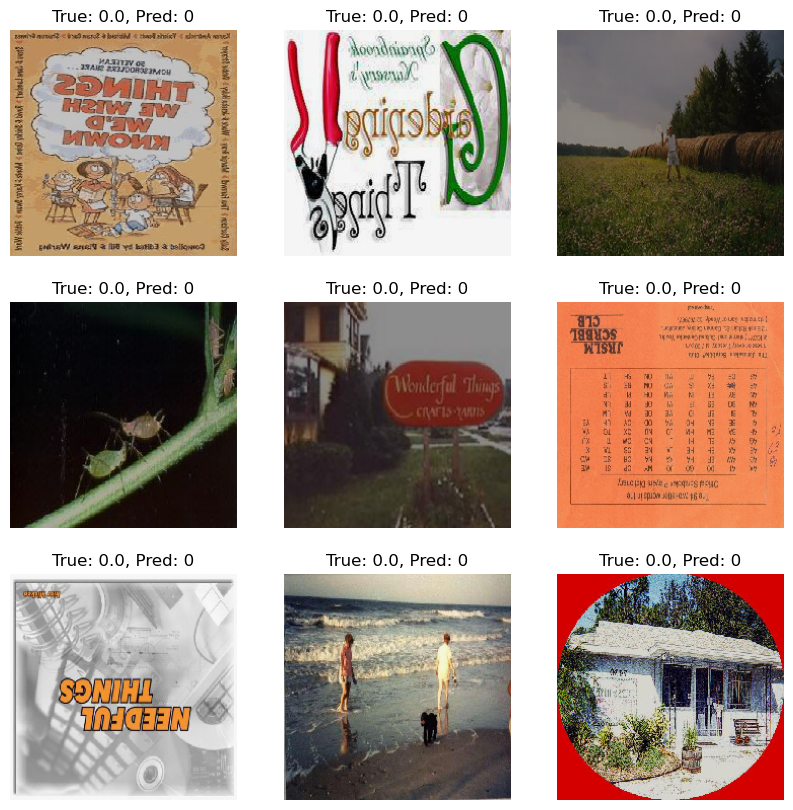

In [16]:
# Function to visualize some predictions
def visualize_predictions(generator, model, num_images=9):
    plt.figure(figsize=(10, 10))
    images, labels = next(generator)
    preds = model.predict(images)
    preds_classes = np.argmax(preds, axis=1)

    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f'True: {labels[i]}, Pred: {preds_classes[i]}')
        plt.axis('off')
    plt.show()

# Visualize predictions
visualize_predictions(validation_generator, model)

In [17]:
### Code to Test on a New Image

In [2]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_on_new_image(img_path, model, class_labels):
    # Load the image
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to 224x224
    img_array = image.img_to_array(img)  # Convert to array
    img_array = img_array / 255.0  # Rescale the image if your model was trained with rescaled images
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Predict the class
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]  # Get the index of the highest prediction
    confidence = np.max(predictions)  # Confidence level for the predicted class
    
    # Map the predicted class index to the actual class label
    predicted_label = class_labels[predicted_class]
    
    # Print the result
    print(f"Predicted Class: {predicted_label} (Confidence: {confidence * 100:.2f}%)")

# Example usage
img_path = r"C:\Users\hp\OneDrive\Desktop\download.jpeg"  # Replace with the path to the new image
class_labels = list(img_generator_flow_train.class_indices.keys())  # Get class labels from the data generator
predict_on_new_image(img_path, model, class_labels)


NameError: name 'img_generator_flow_train' is not defined

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

# Data augmentation
img_generator = ImageDataGenerator(
    brightness_range=(0.5, 1),
    channel_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1.0 / 255,
    validation_split=0.3
)

root_dir = "D:/DL-Practical Main LP IV/caltech-101-img"  # Adjust the path accordingly

# Prepare data generators
img_generator_flow_train = img_generator.flow_from_directory(
    directory=root_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    subset="training",
    class_mode='sparse'  # Use 'sparse' for integer labels
)

img_generator_flow_valid = img_generator.flow_from_directory(
    directory=root_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    subset="validation",
    class_mode='sparse'  # Use 'sparse' for integer labels
)

# Load the VGG16 model without top layers
model_path = r"D:/DL-Practical Main LP IV/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights=model_path)
base_model.trainable = False  # Freeze the base model

# Build the model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(102, activation='softmax')  # Adjust the number of classes as needed
])

# Compile the model
adam = Adam(0.001)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(img_generator_flow_train, 
          validation_data=img_generator_flow_valid, 
          steps_per_epoch=5,
          epochs=10)

# Evaluation
# Predict on validation data
validation_steps = np.ceil(img_generator_flow_valid.samples / img_generator_flow_valid.batch_size)
validation_generator = img_generator.flow_from_directory(
    directory=root_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=False,
    subset="validation",
    class_mode='sparse'  # Use 'sparse' for integer labels
)

# Get predictions
predictions = model.predict(validation_generator, steps=validation_steps)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes

# Generate classification report
print(classification_report(true_classes, predicted_classes, target_names=validation_generator.class_indices.keys()))

# Function to visualize some predictions
def visualize_predictions(generator, model, num_images=9):
    plt.figure(figsize=(10, 10))
    images, labels = next(generator)
    preds = model.predict(images)
    preds_classes = np.argmax(preds, axis=1)

    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f'True: {labels[i]}, Pred: {preds_classes[i]}')
        plt.axis('off')
    plt.show()

# Visualize predictions
visualize_predictions(validation_generator, model)
